# Table of Contents
 <p><div class="lev1 toc-item"><a href="#AfSIS-Soil-Chemistry-Dataset-Usage-Tutorial" data-toc-modified-id="AfSIS-Soil-Chemistry-Dataset-Usage-Tutorial-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>AfSIS Soil Chemistry Dataset Usage Tutorial</a></div><div class="lev2 toc-item"><a href="#Prerequisities" data-toc-modified-id="Prerequisities-11"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Prerequisities</a></div><div class="lev2 toc-item"><a href="#Downloading-the-Soil-Chemistry-Dataset-from-AWS" data-toc-modified-id="Downloading-the-Soil-Chemistry-Dataset-from-AWS-12"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Downloading the Soil Chemistry Dataset from AWS</a></div><div class="lev2 toc-item"><a href="#Loading-OPUS-spectra" data-toc-modified-id="Loading-OPUS-spectra-13"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Loading OPUS spectra</a></div><div class="lev2 toc-item"><a href="#3.-Adding-geographical-references" data-toc-modified-id="3.-Adding-geographical-references-14"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>3. Adding geographical references</a></div><div class="lev2 toc-item"><a href="#4.-Wet-chemistry" data-toc-modified-id="4.-Wet-chemistry-15"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>4. Wet chemistry</a></div><div class="lev2 toc-item"><a href="#Modelling" data-toc-modified-id="Modelling-16"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Modelling</a></div>

# AfSIS Soil Chemistry Dataset - Usage Tutorial¶

QED | https://qed.ai | info@qed.ai  

This tutorial illustrates the kind of data included in the AfSIS Soil Chemistry Dataset hosted at the Registry of Open Data on AWS, and how it can be used in simple descriptive analyses and machine learning models.

## Prerequisities

In this tutorial, we require python3.6 with the following packages installed: 

* To download data:
    * aws-cli
* To parse and manage datasets:
    * brukeropusreader
    * pandas 
    * tqdm
* To make plots:
    * matplotlib
    * folium
    * seaborn
* To train machine learning models:
    * xgboost
    * scikit-learn

You can install all of this packages with one command:

    ! pip install awscli brukeropusreader tqdm pandas matplotlib folium seaborn scikit-learn xgboost           

##  Downloading the Soil Chemistry Dataset from AWS

Download s3 bucket content with the `aws-cli` command line tool. Run `aws configure` beforehand to set your credentials.

In [ ]:
! aws s3 sync s3://afsis afsis

## Loading OPUS spectra

OPUS spectra can be opened with the [brukeropusreader](https://github.com/qedsoftware/brukeropusreader) package. 

The function `brukeropusreader.read_file` parses the binaries and returns a data structure containing information about the wave numbers, absorbance spectra, and file metadata. 
You can change path in variable `SPECTRA_PATH` to choose which files you want to work with.
In this tutorial we will use `Bruker_MPA/*` spectra.

In [3]:
SPECTRA_DIR = 'Bruker_MPA/*'

import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from brukeropusreader import read_file
from tqdm import tqdm_notebook as tqdm

AFSIS_PATH = Path('afsis/2009-2013/Dry_Chemistry/ICRAF/')
names = []
spectra = []
wave_nums = None

for path in tqdm(AFSIS_PATH.glob(SPECTRA_DIR)):
    try:
        if path.is_file():
            spect_data = read_file(path)
            spectra.append(spect_data.spectrum)
            names.append(path.stem)
            wave_nums = spect_data.wave_nums
    except Exception as e:
        print(f'{path.name}: {repr(e)}')
    
column_names = ['{:.3f}'.format(x) for x in wave_nums]
spectra_df = pd.DataFrame(spectra, index=names, columns=column_names)

icr049045.0: NoAbsorbanceSpectra()
icr034522.0: NoAbsorbanceSpectra()
icr030377.0: NoAbsorbanceSpectra()
icr024938.0: error('unpack_from requires a buffer of at least 9228 bytes',)
icr055803.0: NoAbsorbanceSpectra()
icr076385.0: error('unpack_from requires a buffer of at least 4249869848 bytes',)



Here we plot a few of the spectra. 

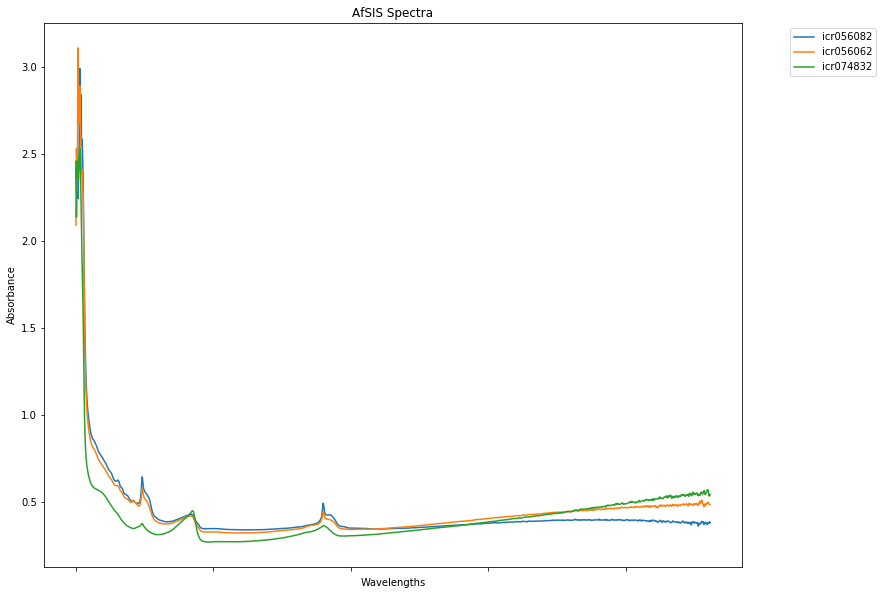

In [25]:
fig = spectra_df.sample(3).T.plot(figsize=(12.5, 10), title='AfSIS Spectra')
fig.set_xlabel("Wavelengths")
fig.set_ylabel("Absorbance")
fig.legend(bbox_to_anchor=(1.2, 1))

## 3. Adding geographical references

The AfSIS Soil Chemistry Dataset contains georeferences for each spectra. 
You can use them to locate every measurement on a map.

In [4]:
GEOREFS_FILE = 'afsis/2009-2013/Georeferences/georeferences.csv'
georefs_df = pd.read_csv(GEOREFS_FILE)

In [ ]:
import folium
m = folium.Map(location=[-3.5, 35.6], tiles="stamentoner", zoom_start=3)
 
for _, row in georefs_df.iterrows():
    if row[['Latitude', 'Longitude']].notnull().all():
        folium.Marker([row['Latitude'], 
                       row['Longitude']], 
                      popup=row['SSN']
                     ).add_to(m)

m

![afsis_map](img/folium.png "AfSIS Map")


You can also count the number of samples in each country:

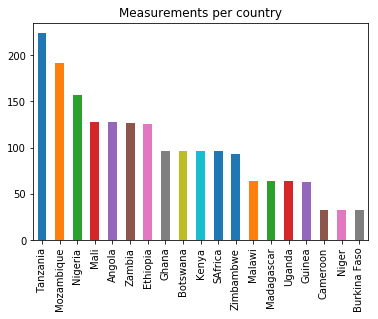

In [6]:
pd.value_counts(georefs_df['Country']).plot.bar(title='Measurements per country')

The georeferences table also contains many other pieces of metadata, as shown below:

In [7]:
georefs_df.head()

,SSN,Public,Latitude,Longitude,Cluster,Plot,Depth,Soil material,Scientist,Site,Country,Region,Cultivated,Gid
0,icr025136,True,-6.851620,34.243313,16,7,sub,NaN,Tor Vagen,Itende,Tanzania,East Africa,False,599
1,icr068579,True,11.280658,8.166768,9,1,top,Pamp.9.1.Topsoil.Std fine soil,Jerome Tondoh,Pampaida,Nigeria,West Africa,NaN,1487
2,icr048978,True,-29.972100,22.710200,1,1,sub,Prie.1.1.Subsoil.Std fine soil,George Van Zijl,Prieska,SAfrica,South Africa,False,786
3,icr056481,True,-16.066365,28.326498,15,1,sub,Mong.15.1.Subsoil.Std fine soil,L.T.Desta,Monga,Zambia,South Africa,True,1065
4,icr034190,True,8.158693,9.930640,15,1,top,Ibi.15.1.Topsoil.Std fine soil,Jerome Tondoh,Ibi,Nigeria,West Africa,True,655


## 4. Wet chemistry

The AfSIS Soil Chemistry dataset contains wet chemistry data taken at each sampling location.

You can select which wet chemistry dataset you want to work with in `WET_CHEM_PATH`variable and which elements you want to plot in `elements` array.

In [9]:
WET_CHEM_PATH = 'afsis/2009-2013/Wet_Chemistry/CROPNUTS/Wet_Chemistry_CROPNUTS.csv'
elements = ['M3 Ca', 'M3 K', 'M3 Al']
columns_to_load = elements + ['SSN']


wet_chem_df = pd.read_csv(WET_CHEM_PATH, index_col='SSN', usecols=columns_to_load)

You can plot the elemental distributions of all loaded samples using the `seaborn` library. 

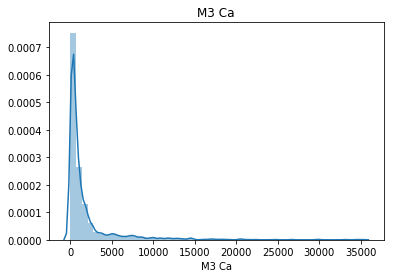

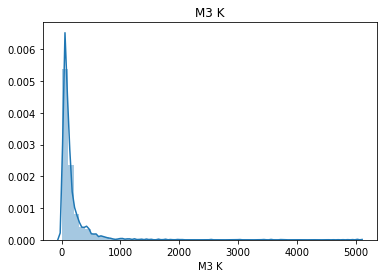

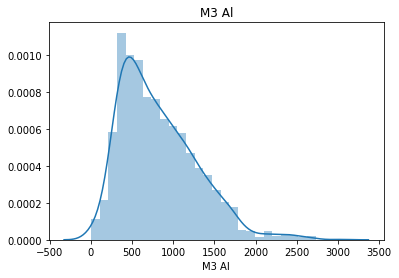

In [10]:
import seaborn as sn

for e in elements:
  sn.distplot(wet_chem_df[e]).set_title(e)
  plt.show()    

We can also check for correlations between any of the wet chemistry pairs. 

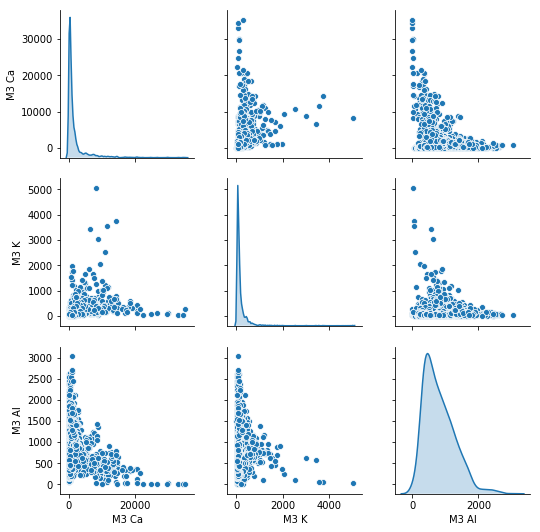

In [11]:
sn.pairplot(wet_chem_df[elements], diag_kind='kde')

## Modelling

Together, the wet chemistry and dry chemistry measurements can serve as a training dataset for performing spectral inference.
Namely, we can prepare algorithmic data models to estimate the elemental concentrations that wet chemistry would have produced, based on spectral measurements. Below is a very simple example of how this can work. 

You can set different wet chemistry path in variable `WET_CHEM_PATH` and different element in variable `Y_COLUMN`. 

In [12]:
WET_CHEM_PATH = 'afsis/2009-2013/Wet_Chemistry/CROPNUTS/Wet_Chemistry_CROPNUTS.csv'
Y_COLUMN = 'M3 Ca'

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold

import numpy as np
from xgboost import XGBRegressor
wet_chem_df = pd.read_csv(WET_CHEM_PATH, index_col='SSN')
data_df = spectra_df.merge(wet_chem_df, left_index=True, right_index=True)

print(f'Training model for {Y_COLUMN}.')
print(f'{data_df.shape[0]} sampels available.')


y = data_df[Y_COLUMN]
y_mask = y.notnull()
y = y[y_mask]
y = np.log1p(y)

x = data_df[column_names]
x = x[y_mask]
x = np.apply_along_axis(np.gradient, 1, x)

kfold = KFold(shuffle=True, random_state=0, n_splits=4)
model = XGBRegressor(n_estimators=500, min_child_weight=20, n_jobs=-1)
    
cv_result = cross_validate(model, x, y, scoring='r2', cv=kfold)['test_score']
print(f'CV r^2 score: {np.mean(cv_result)}')

Training model for M3 Ca.
1901 sampels available.
CV r^2 score: 0.7588735476237644
